# Importing Libraries

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

import sys
import torch.optim as optim

In [3]:
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.9.1+cpu


Here annotations are in xml and images are in png. So xmltodict can be installed for which is a Python module that makes working with XML feel like working with JSON.xmltodict also lets roundtrip back to XML with the unparse function, has a streaming mode suitable for handling files that don’t fit in memory, and supports XML namespaces.

In [4]:
!pip install xmltodict

In [5]:
import xmltodict

# Extraction of Images and Annotations

The OS module in Python provides functions for creating and removing a directory (folder), fetching its contents, changing and identifying the current directory, etc.

Here we are using os.walk() and os.path.join()

* os.walk() returns a generator, that creates a 3-tuple
    * dirpath :- It is a string, with provides the path to the directory.
    * dirnames(in dirpath) : - It is a list of the names of the subdirectories in dirpath (excluding '.' and '..')
    * filenames(in dirpath):- It is a list of the names of the non-directory files in dirpath. 

Every time the generator is called it will follow each directory recursively until no further sub-directories are available from the initial directory that walk was called upon.

* os.path.join(dirpath, name) is used to get a full path (which begins with top) to a file or directory in dirpath. 

You can read more from [here](https://docs.python.org/3/library/os.html#os.walk)


All the images are stored in img_names list and annotations in xml_names list.

In [6]:
img_names = [] 
xml_names = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [7]:
path_annotations = "/kaggle/input/face-mask-detection/annotations/" 
listing = []

for i in img_names[:]:
    with open(path_annotations + i[:-4] + ".xml") as fd:
        doc = xmltodict.parse(fd.read())
    temp = doc["annotation"]["object"]
    if type(temp) == list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()

print(Items,'\n',values)

dict_keys(['with_mask', 'mask_weared_incorrect', 'without_mask']) 
 dict_values([3232, 123, 717])


# Visualisation and Analysis of Target Class

Target Classes belongs to :

* with_mask
* mask_weared_incorrect
* without_mask

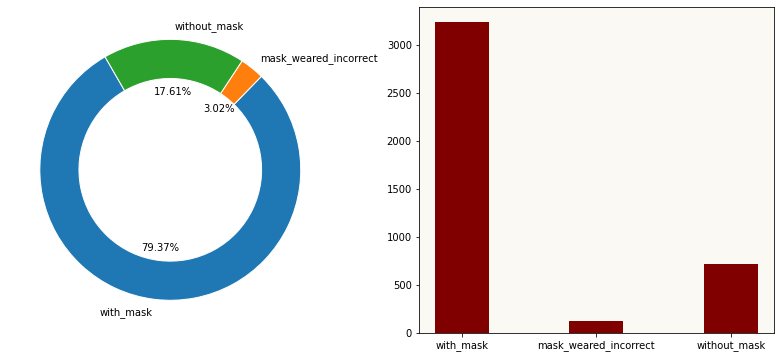

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'

ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 

ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()

Dataset contain images :
    
* with_mask : 79.37%
* mask_weared_incorrect : 3.02%
* without_mask : 17.61%

# Images Identification with Target Class

As there are 3 classes in target, we can use 3 colors for cascading the face.
* Red => without_mask
* Green => with_mask
* Yellow => mask_weared_incorrect

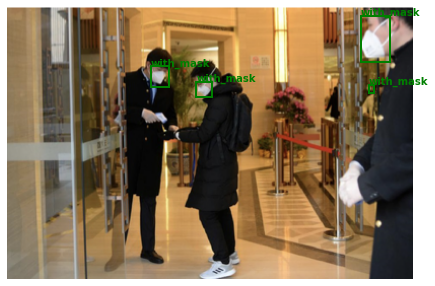

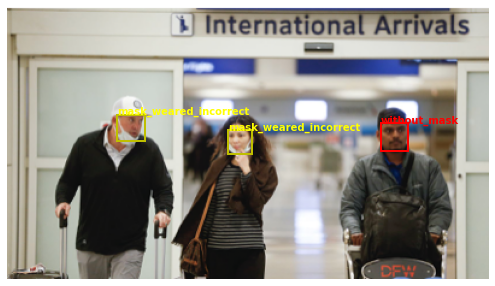

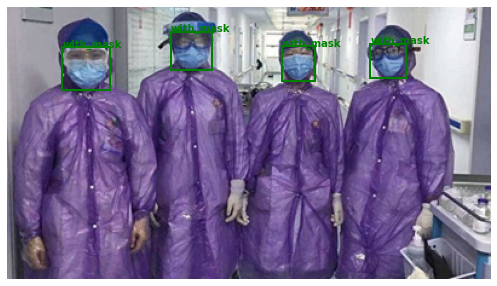

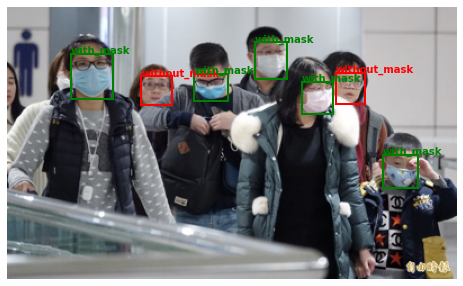

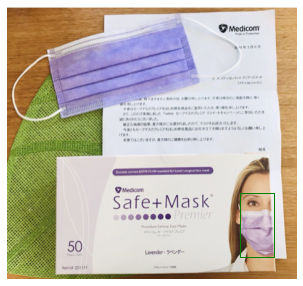

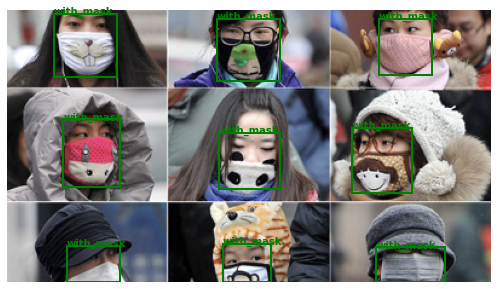

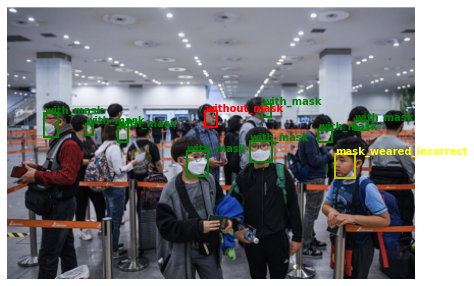

In [9]:
path_image="/kaggle/input/face-mask-detection/images/"  
def face_cas(img): 
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(path_image+img))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            ###with_mask
            if temp[i]["name"]=="with_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            ###without_mask
            if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))     
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            ###mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

fun_images = img_names.copy()
for i in range(1,8):
    face_cas(fun_images[i])

# Image Preprocessing

The Image is preprocessed as PyTorch tensors. The transforms function of torchvision is used to define pipeline of basic data preprocessing.

Functions used for preprocessing are :

*    **xmltodict.parse()** : This is used to parse the given XML input and convert it into a dictionary. 

    Generak syntax of xmltodict.parse() is 
    
    xmltodict.parse(xml_input, encoding='utf-8', expat=expat, process_namespaces=False, namespace_separator=':', **kwargs)
    *     **xml_input** : It can be a either be a string or a file-like object. Here we are using read() method, which reads at most n bytes from file desciptor and return a string containing the bytes read. If the end of file referred to by fd has been reached, an empty string is returned.
    *    **torchvision.transforms.Compose()** : torchvision.transforms is used for common image transformations and when Compose is chained with it to Compose several transforms together.
    *    **transforms.ToTensor()**: This just converts input image to PyTorch tensor.
    *    **torch.tensor()**:  It infers the dtype automatically. It always copies the data and torch.tensor(l) is equivalent to l.clone().detach().
    *    **transforms.Resize()** : The default interpolation is InterpolationMode.BILINEAR. It resize the input image as per the height and width provided. 
    *    **transforms.functional.crop()** : Crop the given image at specified location and output size and it returs torch.Tensor.
    
    
With preprocessed Images dataset is created and then we can split the dataset to training and test set. 
  
    

In [10]:
options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} 

In [11]:
def dataset_creation(image_list): 
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"])!=list:
            temp=doc["annotation"]["object"]
            x,y,w,h=list(map(int,temp["bndbox"].values()))
            label=options[temp["name"]]
            image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"),y,x,h-y,w-x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
                
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

mydataset=dataset_creation(img_names)

In mathematics, a tensor is an algebraic object that describes a multilinear relationship between sets of algebraic objects related to a vector space. The dataset created will be of tensor.

In [12]:
mydataset[0]

[tensor([[[0.3176, 0.3412, 0.3882,  ..., 0.1686, 0.1725, 0.1725],
          [0.3216, 0.3373, 0.3647,  ..., 0.1647, 0.1686, 0.1686],
          [0.3294, 0.3294, 0.3216,  ..., 0.1608, 0.1608, 0.1608],
          ...,
          [0.0745, 0.0745, 0.0745,  ..., 0.6471, 0.6431, 0.6431],
          [0.0706, 0.0706, 0.0706,  ..., 0.6431, 0.6392, 0.6392],
          [0.0706, 0.0706, 0.0667,  ..., 0.6392, 0.6392, 0.6392]],
 
         [[0.3333, 0.3569, 0.4078,  ..., 0.1137, 0.1176, 0.1216],
          [0.3373, 0.3490, 0.3804,  ..., 0.1098, 0.1137, 0.1176],
          [0.3412, 0.3412, 0.3373,  ..., 0.1059, 0.1059, 0.1098],
          ...,
          [0.0706, 0.0706, 0.0667,  ..., 0.4314, 0.4353, 0.4353],
          [0.0706, 0.0706, 0.0706,  ..., 0.4353, 0.4392, 0.4392],
          [0.0706, 0.0706, 0.0706,  ..., 0.4392, 0.4392, 0.4392]],
 
         [[0.3412, 0.3608, 0.4000,  ..., 0.0980, 0.1020, 0.1059],
          [0.3451, 0.3529, 0.3765,  ..., 0.0941, 0.0980, 0.1020],
          [0.3490, 0.3451, 0.3412,  ...,

# Splitting Dataset into Training and Test Set

In [13]:
train_size=int(len(mydataset)*0.7)
test_size=len(mydataset)-train_size
print('Length of dataset is', len(mydataset), '\nLength of training set is :',train_size,'\nLength of test set is :', test_size)

Length of dataset is 4072 
Length of training set is : 2850 
Length of test set is : 1222


To split dataset, torch.utils.data.random_split() is used which randomly splits the dataset into non-overlapping new datasets of given lengths.

In [14]:
trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])

# Samples in Training Set

DataLoader() is an iterable that abstracts this complexity for us in an easy API. When shuffle is made true data is shuffled, after the iteration is over for all batches.


In [15]:
train_dataloader =DataLoader(dataset=trainset,batch_size=32,shuffle=True,num_workers=4)
test_dataloader =DataLoader(dataset=testset,batch_size=32,shuffle=True,num_workers=4)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

In [17]:
import sys
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 226, 226])
Labels batch shape: torch.Size([32])


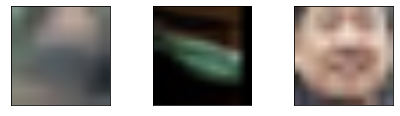

In [18]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
    
train_features_np=train_features.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(3):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(train_features_np[idx],(1,2,0)))
    

# Model Building

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#9041A0;
           font-size:110%;
           font-family:Segoe UI;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
    ResNet - Deep Residual Learning for Image Recognition
             </p> </div>



The Residual Network, or ResNet for short, is a model that makes use of the residual module.There are several variants of different sizes, including Resnet18, Resnet34, Resnet50, Resnet101, and Resnet152, all of which are available from torchvision models. **Here Resnet34 model is used.**

When deeper networks are able to start converging, degradation problem occurs. As the network depth increases, the accuracy gets saturated and then degrades rapidly. These degradation is not caused by overfitting, and adding
more layers to a suitably deep model leads to higher training error. Degradation indicates **not** all systems are similarly easy to optimize.

Deep residual learning framework address the degradation problem. Instead of hoping each few stacked layers directly fit a desired underlying mapping,   these layers are explicitly made to fit a residual mapping.

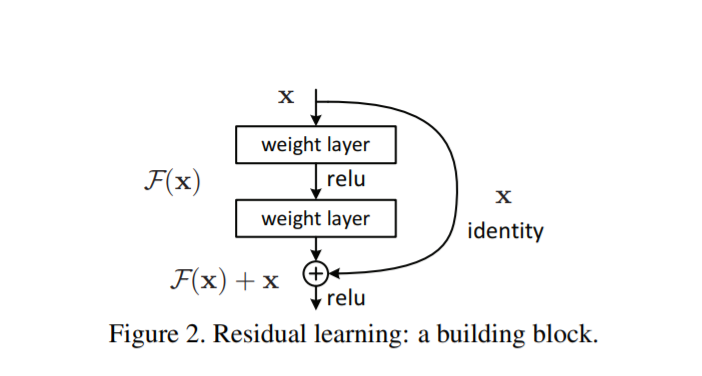

The formulation of F(x) +x can be realized by feedforward neural networks with “shortcut connections”. The shortcut connections here simply perform identity mapping, and their outputs are added to the outputs of the stacked layers.The entire network can still be trained end-to-end by SGD with backpropagation, and can be easily implemented using common libraries without modifying the solvers.

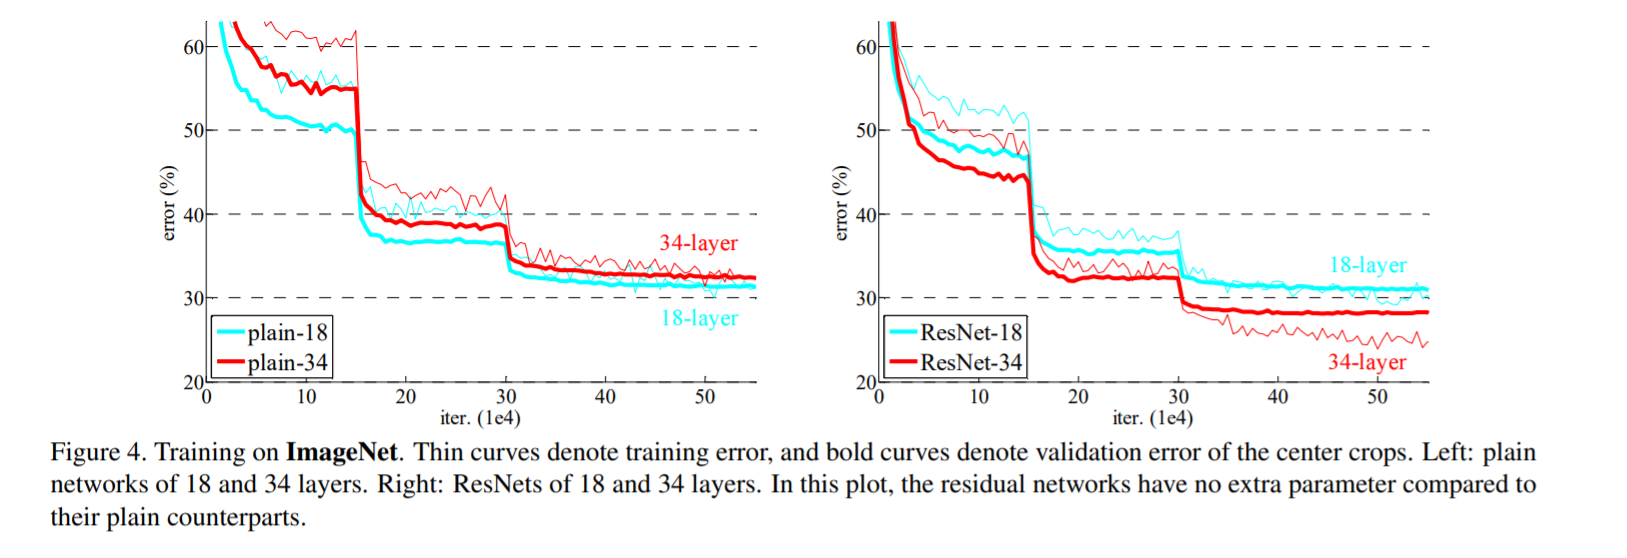

# Download the resnet34 layers pre-trained model

In torchvision.models.resnet34(), when pretrained is provided as True, it returns a model pre-trained on ImageNet.


In [19]:
model=models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

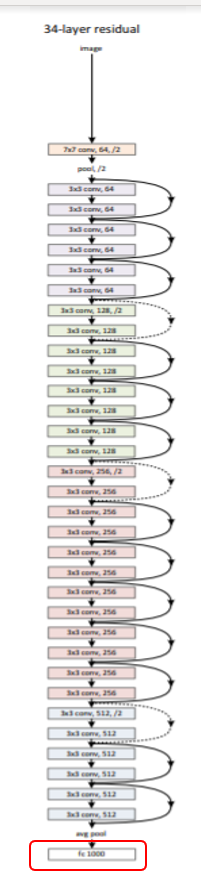

# Feature Extraction

In [20]:
for param in model.parameters():
    param.requires_grad=False

 Setting Model Parameters, attribute requires_grad to false when feature extraction is done.

# Model Details


To view different layers representing different operations 'model name' is to be executed.

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The last layer of the downloaded model screenshot is below 

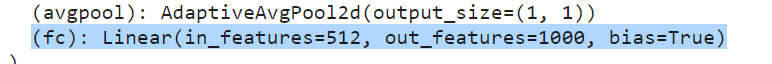

It indicates out_features is equal to 1000, so it must reinitialize model to be a Linear layer with 512 input features and 3 output class.

**torch.nn.Linear()** applies a linear transformation to the incoming data: 

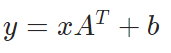




In [22]:
import torch.nn as nn
n_inputs=model.fc.in_features
last_layer=nn.Linear(n_inputs,3)

model.fc.out_features=last_layer
print('reinitialize model with output features as 3 :', model.fc.out_features)

reinitialize model with output features as 3 : Linear(in_features=512, out_features=3, bias=True)


In [23]:
features_resnet34 = []
for key,value in model._modules.items():
    features_resnet34.append(value)

features_resnet34

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

**Now last layer shows out_features as 3.**

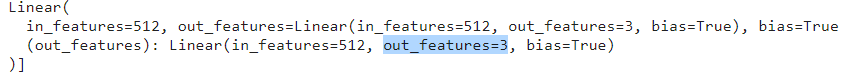

# Calculating Parameters of Convolutional Layer 

## 2D convolutional layer

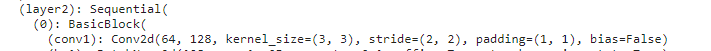

We have general syntax for convolutional2D layer as 

nn.Conv2d(in_channels, out_channels, kernel_size, stride) here in resnet34 it is like nn.Conv2d(64, 128, kernel_size = (3,3), stride=(3,3)), so number of parameters for this conv2D can be calculated as:

in_channels * out_channels * filter_height * filter_width 

In [24]:
conv_param = 64 * 128 * 3 * 3
print(' Number of Parameters for conv2D is :', conv_param )

 Number of Parameters for conv2D is : 73728


## CrossEntropyLoss

The loss for the model is to be set, then run the training and validation function for the set number of epochs. Notice, depending on the number of epochs this step may take a while on a CPU. Also, the default learning rate is not optimal for all of the models, so to achieve maximum accuracy it would be necessary to tune for each model separately.

In [25]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

# Training Model

param.requires_grad will be which is by default True for feature extraction we have set it False. When it is True  backpropagration will be there. In order for the model to avoide overfitting, layers is to be freezed.

In order to freeze a layer, requires_grad is to be set to False. Here setting freezeing layers from 1 to 6.

In [26]:
param.requires_grad=True
ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

In [27]:
n_epochs=10

for epoch in range(n_epochs): 
    running_loss = 0.0
    train_losses = []
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()
        
        #inputs = inputs.to(device)
        #labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
        if i % 20 == 19:    
                
                print("Epoch {}, batch {}, training loss {}".format(epoch, i+1,running_loss/20))
        
        running_loss = 0.0

print('\nFinished Training')

Epoch 0, batch 20, training loss 0.4666584491729736
Epoch 0, batch 40, training loss 0.46427149772644044
Epoch 0, batch 60, training loss 0.4469479560852051
Epoch 0, batch 80, training loss 0.4492341041564941
Epoch 1, batch 20, training loss 0.43632969856262205
Epoch 1, batch 40, training loss 0.4375558376312256
Epoch 1, batch 60, training loss 0.4337587356567383
Epoch 1, batch 80, training loss 0.39513406753540037
Epoch 2, batch 20, training loss 0.4017298698425293
Epoch 2, batch 40, training loss 0.38698339462280273
Epoch 2, batch 60, training loss 0.409633731842041
Epoch 2, batch 80, training loss 0.3995919704437256
Epoch 3, batch 20, training loss 0.39365994930267334
Epoch 3, batch 40, training loss 0.3778583288192749
Epoch 3, batch 60, training loss 0.3724390506744385
Epoch 3, batch 80, training loss 0.35011699199676516
Epoch 4, batch 20, training loss 0.34666659832000735
Epoch 4, batch 40, training loss 0.3400917053222656
Epoch 4, batch 60, training loss 0.3315412521362305
Epoch 

## Save Model

In [28]:
torch.save(model, "./pytorch_model.pt")

// TODO : output single image

In [1]:
test_image = '../input/face-mask-detection/images/maksssksksss113.png'
output = model(test_image)

NameError: name 'model' is not defined